# A - Preliminary Steps

## Packages Importation

In [5]:
library(corrplot)
library(ggplot2)
library(lattice)
library(rpart)
library(partykit)
library(randomForest)
library(ROCR)
library(caret)
library(missForest)
library(reshape2)
library(FactoMineR)
library(factoextra)
library(rgl)
library(plotly)
library(dplyr)
library(gridExtra)
library(bestglm)
library(MASS)
library(VGAM)

Loading required package: stats4
Loading required package: splines

Attaching package: ‘VGAM’

The following object is masked from ‘package:caret’:

    predictors



## Dataset Importation

http://archive.ics.uci.edu/ml/datasets/Energy+efficiency

In [19]:
data.complet <- read.csv('DataEnergy.csv')
x <- data.complet
head(x)

Relative.compactness Surface.area Wall.area Roof.area Overall.height
1 0.9829276            530.4900     306.4846  112.0027  7             
2 0.9835473            519.8724     299.7763  110.0480  7             
3 0.9794535            516.1912     303.3744  106.4084  7             
4 0.9777325            518.9241     292.8122  113.0559  7             
5 0.9030294            552.9689     316.2361  118.3664  7             
6 0.8909102            558.6037     314.9162  121.8437  7             
  orientation Glazing.area  Glazing.area.distr Energy   Energy.efficiency
1 North        1.609490e-02 0                  34.26394 B                
2 East        -9.386813e-03 0                  34.58975 B                
3 South       -6.974937e-04 0                  38.77805 C                
4 West         9.554434e-06 0                  37.94781 C                
5 North       -6.592326e-03 0                  47.67586 D                
6 East        -1.612145e-02 0                  41.90847 C

**Variables Explanation  :**

* **Relative compactness** : Compacité relative (propriété lié la forme du batiment et sa surface)
* **Surface area** : Superficie
* **Wall area** : Surface des murs
* **Roof area** : Surface du toit
* **Overal height** : Hauteur générale (Qualitatifs ordonnées car 2 valeurs : 3,5 et 7)
* **Orientation** : North East South West
* **Glazing area** : Surface de vitre présente sur la façade
* **Glazing area distr** : Six niveaux : 
* **Energy** : quantifie les performances du batiment 
* **Energy efficiency** : Lettre correspondant à l'efficacité énergétique (seuil de Load)

## Data Cleaning and Transformation 

In [20]:
str(x)

'data.frame':	768 obs. of  10 variables:
 $ Relative.compactness: num  0.983 0.984 0.979 0.978 0.903 ...
 $ Surface.area        : num  530 520 516 519 553 ...
 $ Wall.area           : num  306 300 303 293 316 ...
 $ Roof.area           : num  112 110 106 113 118 ...
 $ Overall.height      : num  7 7 7 7 7 7 7 7 7 7 ...
 $ orientation         : Factor w/ 4 levels "East","North",..: 2 1 3 4 2 1 3 4 2 1 ...
 $ Glazing.area        : num  1.61e-02 -9.39e-03 -6.97e-04 9.55e-06 -6.59e-03 ...
 $ Glazing.area.distr  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Energy              : num  34.3 34.6 38.8 37.9 47.7 ...
 $ Energy.efficiency   : Factor w/ 7 levels "A","B","C","D",..: 2 2 3 3 4 3 3 3 4 4 ...


## Variables Transformation

In [21]:
x$Glazing.area.distr <-as.factor(x$Glazing.area.distr)
levels(x$Glazing.area.distr) <- c("Uniform", "55% North", "55% East", 
                                  "55% South", "55% West", "No glazing")


x$Energy.efficiency <- factor(x$Energy.efficiency, ordered=TRUE)
#options(repr.plot.width = 8, repr.plot.height = 3) 
#histogram(x$Glazing.area.distr, main ="Repartition selon les Glazing Area", xlab="Glazing Area")
#x$Energy[x$Load<=30] = 'A'
#x$Energy[x$Load>30 & x$Load<=35] = 'B'
#x$Energy[x$Load>35 & x$Load<=45] = 'C'
#x$Energy[x$Load>45 & x$Load<=55] = 'D'
#x$Energy[x$Load>55 & x$Load<=65] = 'E'
#x$Energy[x$Load>65 & x$Load<=75] = 'F'
#x$Energy[x$Load>75] = 'G'

In [22]:
summary(x)

 Relative.compactness  Surface.area     Wall.area       Roof.area    
 Min.   :0.6125       Min.   :501.4   Min.   :234.3   Min.   :105.3  
 1st Qu.:0.6779       1st Qu.:598.7   1st Qu.:291.8   1st Qu.:137.4  
 Median :0.7517       Median :673.1   Median :315.8   Median :183.3  
 Mean   :0.7645       Mean   :671.3   Mean   :318.3   Mean   :176.5  
 3rd Qu.:0.8350       3rd Qu.:744.6   3rd Qu.:343.0   3rd Qu.:220.5  
 Max.   :0.9912       Max.   :826.0   Max.   :425.8   Max.   :225.8  
                                                                     
 Overall.height orientation  Glazing.area       Glazing.area.distr
 Min.   :3.50   East :192   Min.   :-0.02401   Uniform   : 48     
 1st Qu.:3.50   North:192   1st Qu.: 0.10306   55% North :144     
 Median :5.25   South:192   Median : 0.24752   55% East  :144     
 Mean   :5.25   West :192   Mean   : 0.23435   55% South :144     
 3rd Qu.:7.00               3rd Qu.: 0.39119   55% West  :144     
 Max.   :7.00               Max.   : 0

On remarque des valeurs négatives pour la variable Glazing Area, ces dernières sont dues à un bruit rajouté. 

In [35]:
summary(x[which(x$Glazing.area<0),]$Glazing.area.distr)

Uniform  55% North   55% East  55% South   55% West No glazing 
        24          0          0          0          0          0

D'après le resultat ci-dessus, toutes les valeurs de Glazing.area inférieures à 0 n'appartiennent pas à la catégorie No glazing. On ne peut donc pas forcer leur valeur à 0. 

Ainsi, on utilise un algorithme de MissForest dans le but de coller au plus près à leur valeur d'origine qui doit
être supérieure à 0.

3.125 % données manquantes dans la variable Glazing area 

  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!
  missForest iteration 4 in progress...done!
  missForest iteration 5 in progress...done!


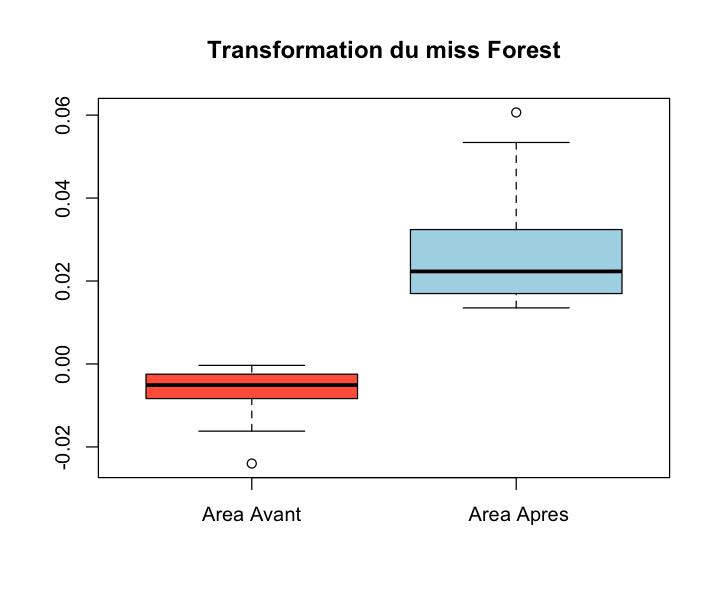

In [36]:
options(repr.plot.width = 6, repr.plot.height = 5) 

## ATTENTION RUN UNE FOIS SEULEMENT 
xcop <-x
xcop$Glazing.area[xcop$Glazing.area<0] <- NA
cat(sum(is.na(xcop$Glazing.area))/length(xcop$Glazing.area)*100,"% données manquantes dans la variable Glazing area \n\n")
Xna <- missForest(xcop)
#summary(Xna$ximp)
a <- which(is.na(xcop$Glazing.area))
boxplot(x$Glazing.area[a],Xna$ximp$Glazing.area[a], main = "Transformation du miss Forest", col=c('tomato1','lightblue'), names=c('Area Avant',' Area Apres')) 
x<- Xna$ximp

# B - Data Analysis

## 1) Univariate Statistics

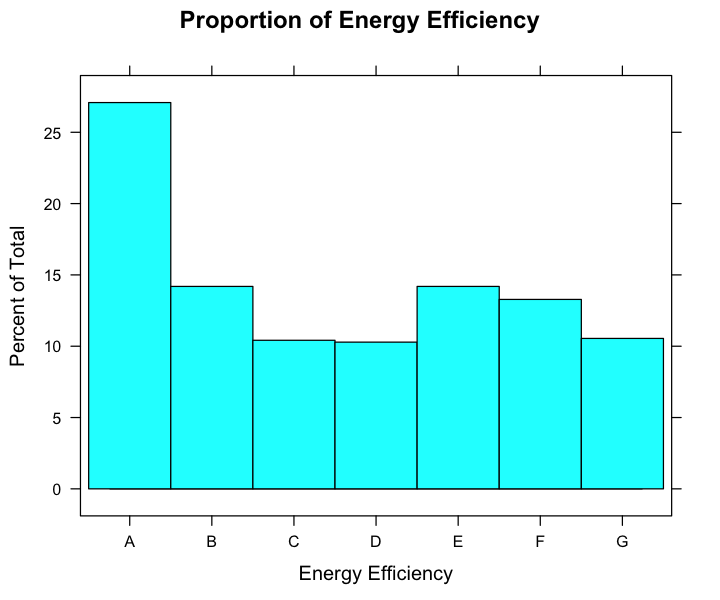

In [37]:
histogram(x$Energy.efficiency, freq=FALSE, xlab="Energy Efficiency", main="Proportion of Energy Efficiency")

**Commentaire :**
La répartition des classes dans le jeu de données est assez uniforme, mis à part la classe A qui est majoritaire.

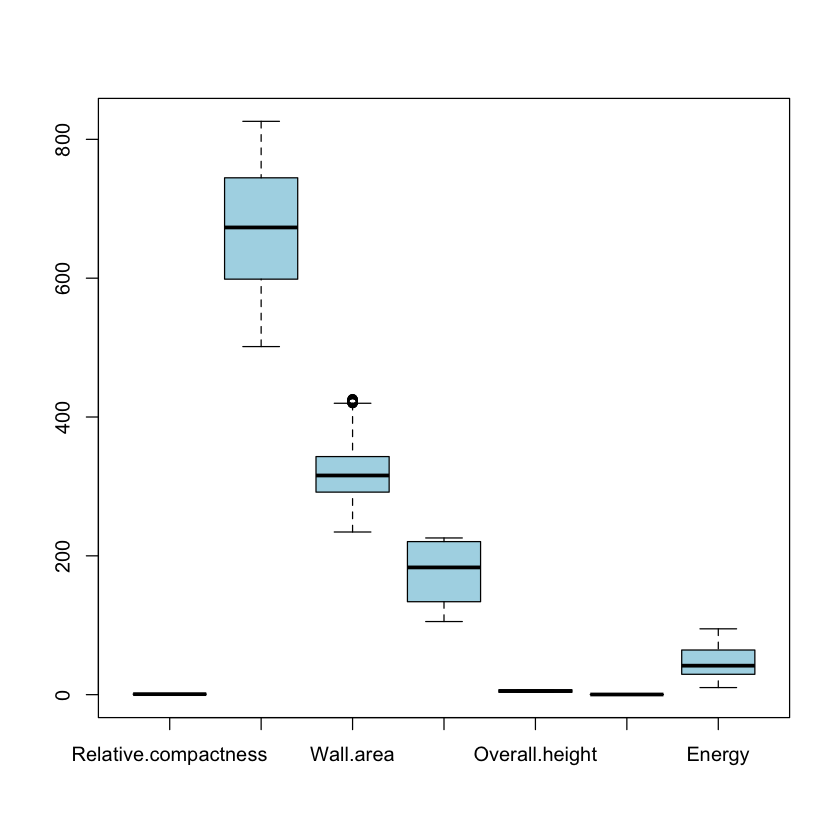

In [38]:
options(repr.plot.width = 7, repr.plot.height = 7) 
boxplot(x[,-c(6,8,10,11)], col='lightblue') #Add legend Add inclinaison
#Pas dans le même ordre de grandeur -> norm = True pendant ACP

**Commentaire :** Les variables ne sont pas toutes de même ordre de grandeur. Les distributions semblent homogènes.

Il faut maintenant étudier plus précisemment la répartition des variables mal représentées sur le graphique.

DEMANDER AU PROF

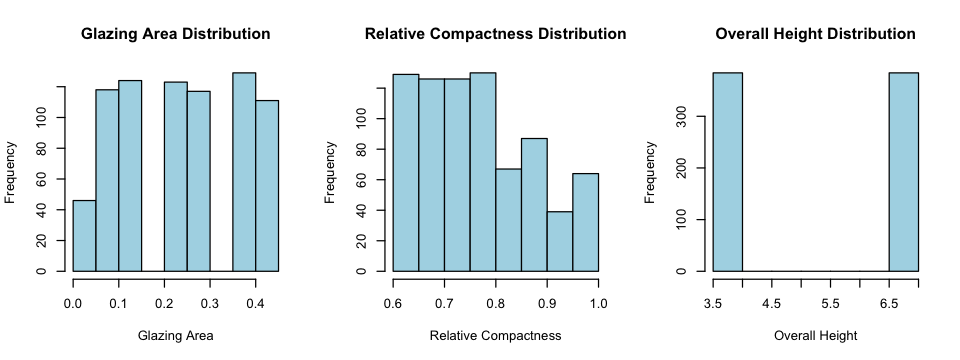

In [40]:
par(mfrow=c(1,3))
options(repr.plot.width = 8, repr.plot.height = 3) 

hist(x$Glazing.area, xlab='Glazing Area', main='Glazing Area Distribution',col='lightblue')
hist(x$Relative.compactness,,xlab= 'Relative Compactness' ,main = 'Relative Compactness Distribution',col='lightblue')
hist(x$Overall.height, xlab ='Overall Height',  main = 'Overall Height Distribution',col='lightblue')

**Commentaire :** Au premier abord, il n'y a pas de transformation de variables nécessaires car les distributions sont "symétriques".

CF PROF

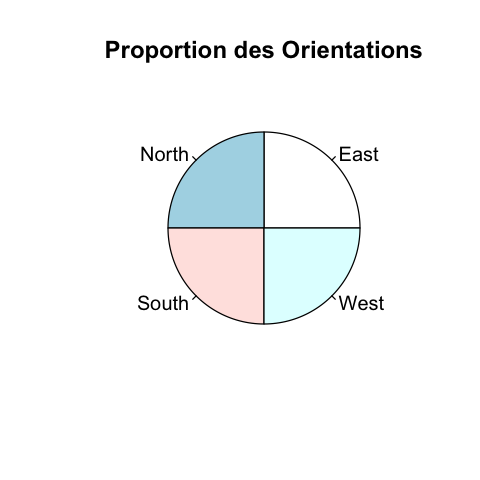

In [62]:
options(repr.plot.width = 4, repr.plot.height = 4) 
pie(table(x$orientation), main = "Proportion des Orientations")

La répartitions des orientations des bâtiments est uniforme.

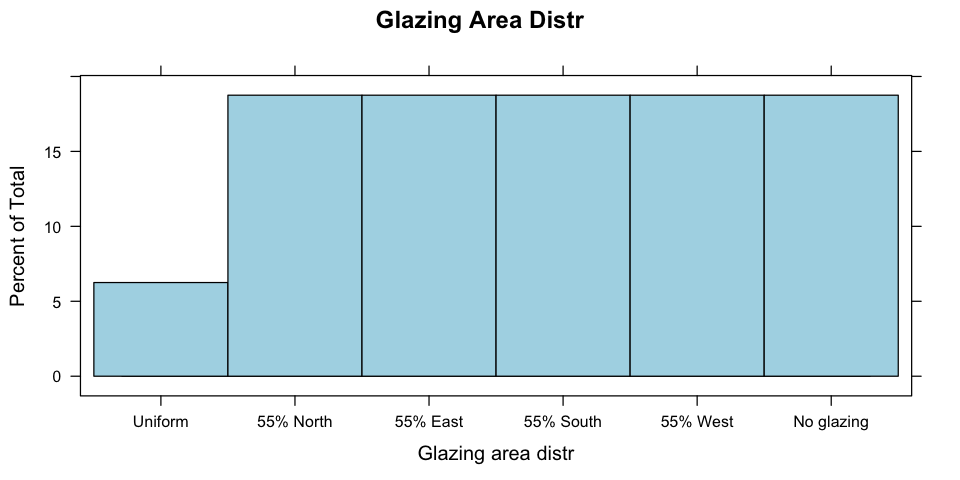

In [64]:
options(repr.plot.width = 8, repr.plot.height = 4) 
histogram(x$Glazing.area.distr,xlab= 'Glazing area distr' ,main = 'Glazing Area Distr',col='lightblue')

La répartition des orientations des vitrages est équitablement répartie entre 55% Nord, 55% Est, 55% Sud, 55% Ouest et sans vitrage. Cependant, l'orientation des vitrages de type "uniform" est minoritaire.

(Cet élément est à prendre en compte dans la suite de l'analyse)

## 2) Multivariate Statistics

In [67]:
M

Relative.compactness Surface.area  Wall.area    
Relative.compactness  1.000000000         -0.9881515651 -0.2012259470
Surface.area         -0.988151565          1.0000000000  0.1984496471
Wall.area            -0.201225947          0.1984496471  1.0000000000
Roof.area            -0.866346048          0.8792559589 -0.2923875060
Overall.height        0.824762660         -0.8546553103  0.2836344103
Glazing.area         -0.003073529          0.0006857216 -0.0007091635
Energy                0.614010981         -0.6500534802  0.4385358783
                     Roof.area    Overall.height Glazing.area  Energy    
Relative.compactness -0.866346048  0.8247626602  -0.0030735294  0.6140110
Surface.area          0.879255959 -0.8546553103   0.0006857216 -0.6500535
Wall.area            -0.292387506  0.2836344103  -0.0007091635  0.4385359
Roof.area             1.000000000 -0.9717428640   0.0010137272 -0.8473963
Overall.height       -0.971742864  1.0000000000  -0.0007730772  0.8781885
Glazing.area          0.001013727 -0.0007730772   1.0000000000  0.2450665
Energy               -0.847396286  0.8781885124   0.2450665413  1.0000000

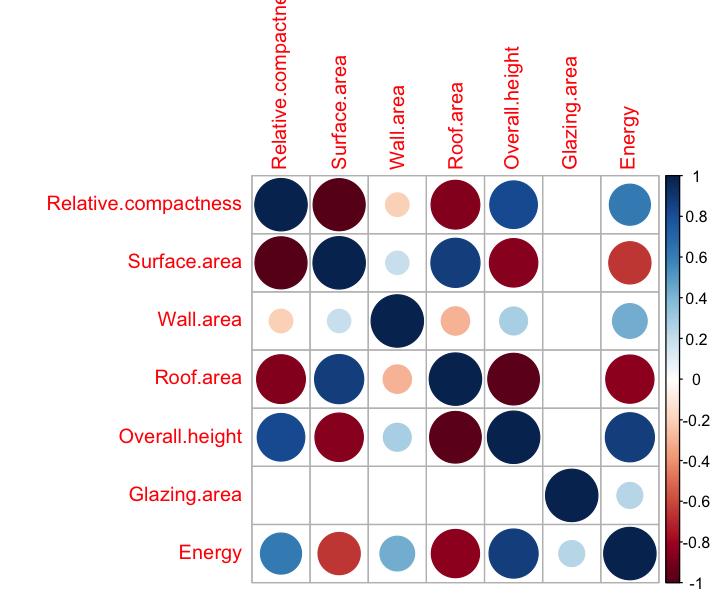

In [66]:
options(repr.plot.width = 6, repr.plot.height = 5) 
M <- cor(x[,-c(6,8,10,11)])
corrplot(M)

**Commentaire :**

Les variables sont globalement très corrélées entre elles. 

   * **Relative compactness** est très fortement correlé négativement avec Surface area (-0.98) et Roof Area (-0.87). Relative compactness est également correlé positivement avec Overall.height. Il doit exister un lien numérique entre ces variables que nous étudierons par la suite.

   * **Overall.height** est très corrélé avec Energy 
    
Il est difficile de tirer des conclusions avec le graphique des corrélations. Regardons la matrice de scatterplots.

*(%A confirmer Une hypothèse serait que les batiments ont la même forme, ainsi seule la surface influe sur cette propriété.*

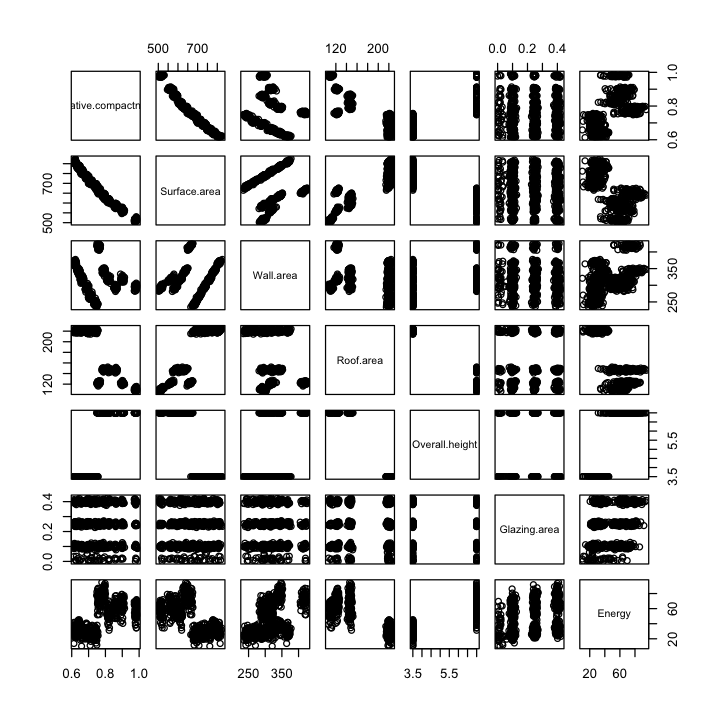

In [71]:
options(repr.plot.width = 6, repr.plot.height = 6)
pairs(x[,-c(6,8,10,11)])

On remarque une relation linéaire entre Relative.compactness et Surface.area

On voit que Glazing.area, qui est une variable quantitative, est finalement répartie selon 4 intervalles.

In [68]:

fig <- plot_ly(x, x = ~Roof.area, y = ~Wall.area, z = ~Surface.area, color = ~Energy.efficiency)
fig <- fig %>% add_markers()
fig <- fig %>% layout(scene = list(xaxis = list(title = 'Roof Area'),
                     yaxis = list(title = 'Wall Area'),
                     zaxis = list(title = 'Surface Area')))

fig

Warning message:
“`arrange_()` is deprecated as of dplyr 0.7.0.
Please use `arrange()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”

HTML widgets cannot be represented in plain text (need html)

In [73]:
## On vérifie la relation Surface.area = Wall.area + 2*Roof.area
a=x$Surface.area-(x$Wall.area+2*x$Roof.area)
cat("Nombre de valeurs pour lesquelles la relation 'Surface.area = Wall.area + 2*Roof.area' n'est pas vérifié : ", length(which(round(a,3)!=0)))

Nombre de valeurs pour lesquelles la relation 'Surface.area = Wall.area + 2*Roof.area' n'est pas vérifié :  0

La surface est calculée en sommant la surface des murs et en ajoutant deux fois la surface du toit.

La relation étant vérifiée pour tous les points de notre jeu de donnée, nous allons pouvoir supprimer une ou plusieurs variables étant donné que les informations sont redondantes.

Pour continuer l'analyse, on va donc supprimer la surface totale qui regroupe deux informations importantes.
On voit en effet sur le plot suivant que ce sont la surface de mur et la surface de toit qui contiennent des informations.

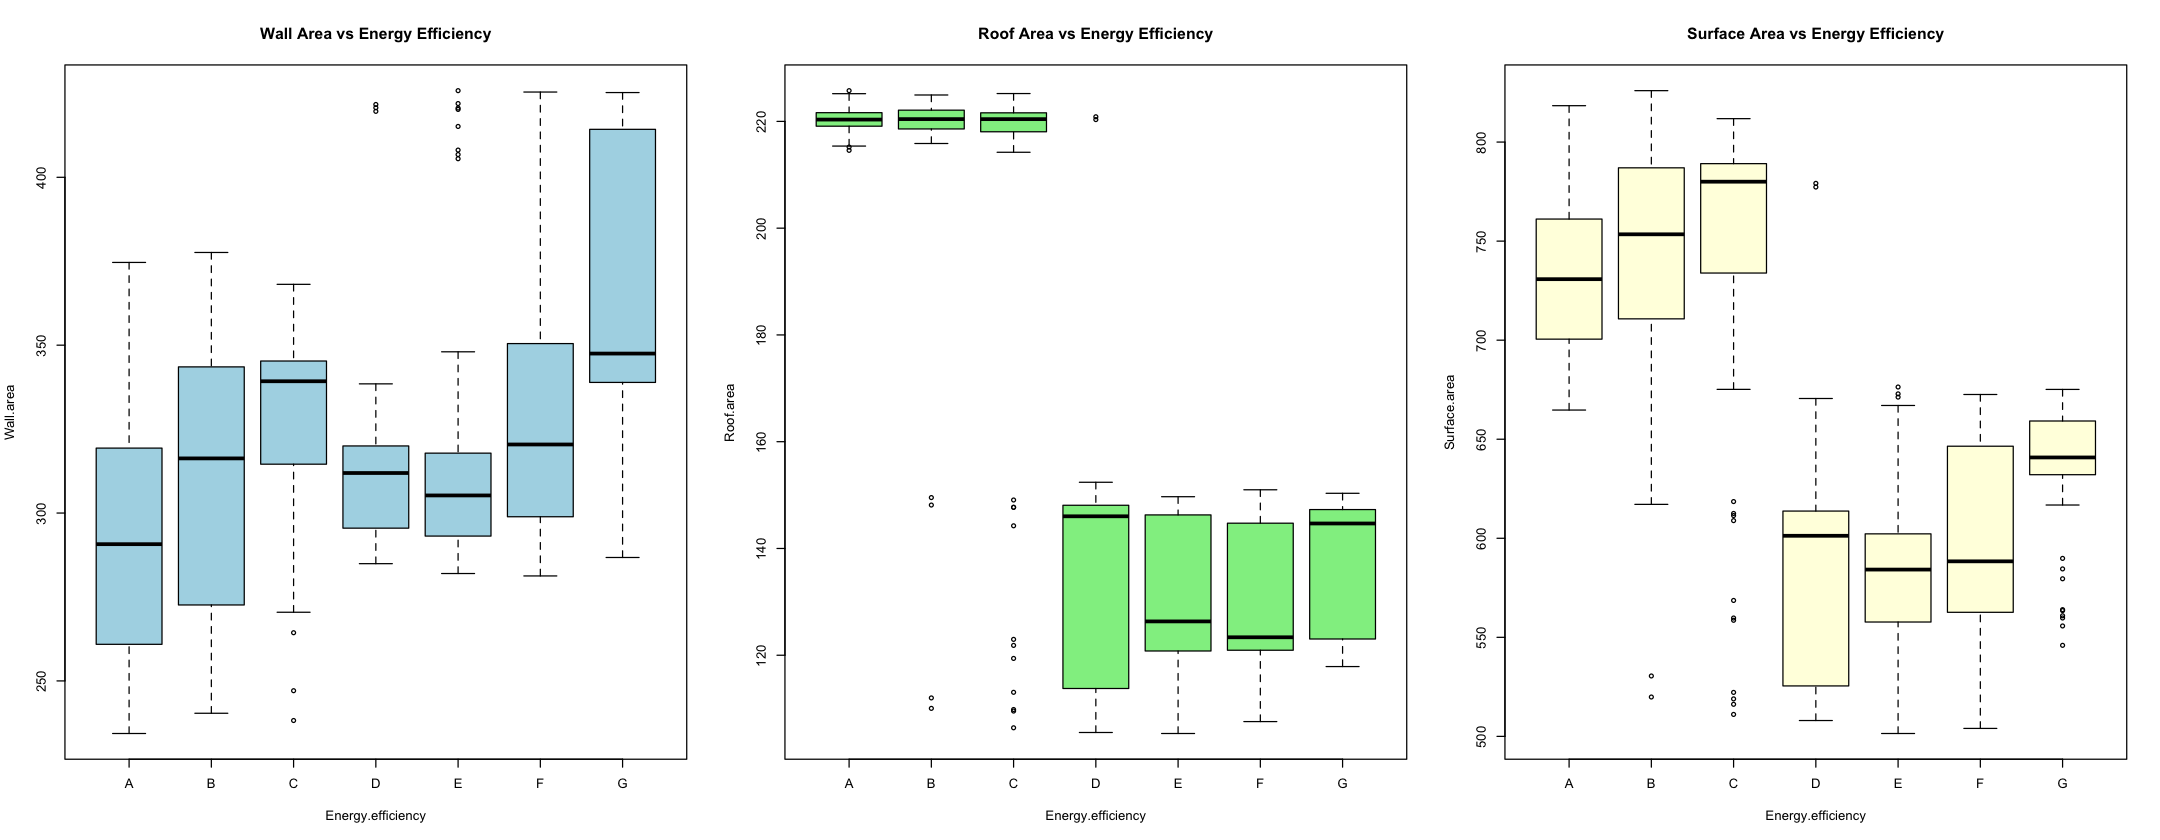

In [75]:
#En cours d'esai sera modifié prochaine séance
options(repr.plot.width = 18, repr.plot.height = 7) 
#par(mfrow=c(1,2))
#table1<-table(x$Load,x$orientation)
#table2<-table(x$Survived, x$Pclass)
#mosaicplot(table1, main="Sex vs Survived")
#mosaicplot(table2, main="Class vs Survived")
par(mfrow=c(1,3))
boxplot(Wall.area ~Energy.efficiency, data=x, col='lightblue', main="Wall Area vs Energy Efficiency")
boxplot(Roof.area ~Energy.efficiency, data=x, col='lightgreen', main="Roof Area vs Energy Efficiency")
boxplot(Surface.area ~Energy.efficiency, data=x, col='lightyellow', main="Surface Area vs Energy Efficiency")


On remarque sur ces graphiques que les classes A, B et C ont une surface de toît élevée. De la même façon, ces classes ont une surface totale élevée.

La tendance est inversée pour les classes D, E, F et G.

**On retire donc la variable Surface Area.**

In [76]:
head(x)

Relative.compactness Surface.area Wall.area Roof.area Overall.height
1 0.9829276            530.4900     306.4846  112.0027  7             
2 0.9835473            519.8724     299.7763  110.0480  7             
3 0.9794535            516.1912     303.3744  106.4084  7             
4 0.9777325            518.9241     292.8122  113.0559  7             
5 0.9030294            552.9689     316.2361  118.3664  7             
6 0.8909102            558.6037     314.9162  121.8437  7             
  orientation Glazing.area Glazing.area.distr Energy   Energy.efficiency
1 North       1.609490e-02 Uniform            34.26394 B                
2 East        1.352408e-02 Uniform            34.58975 B                
3 South       2.228103e-02 Uniform            38.77805 C                
4 West        9.554434e-06 Uniform            37.94781 C                
5 North       1.567076e-02 Uniform            47.67586 D                
6 East        1.425691e-02 Uniform            41.90847 C

In [77]:
x <- dplyr::select(x,-Surface.area)
head(x)

Relative.compactness Wall.area Roof.area Overall.height orientation
1 0.9829276            306.4846  112.0027  7              North      
2 0.9835473            299.7763  110.0480  7              East       
3 0.9794535            303.3744  106.4084  7              South      
4 0.9777325            292.8122  113.0559  7              West       
5 0.9030294            316.2361  118.3664  7              North      
6 0.8909102            314.9162  121.8437  7              East       
  Glazing.area Glazing.area.distr Energy   Energy.efficiency
1 1.609490e-02 Uniform            34.26394 B                
2 1.352408e-02 Uniform            34.58975 B                
3 2.228103e-02 Uniform            38.77805 C                
4 9.554434e-06 Uniform            37.94781 C                
5 1.567076e-02 Uniform            47.67586 D                
6 1.425691e-02 Uniform            41.90847 C

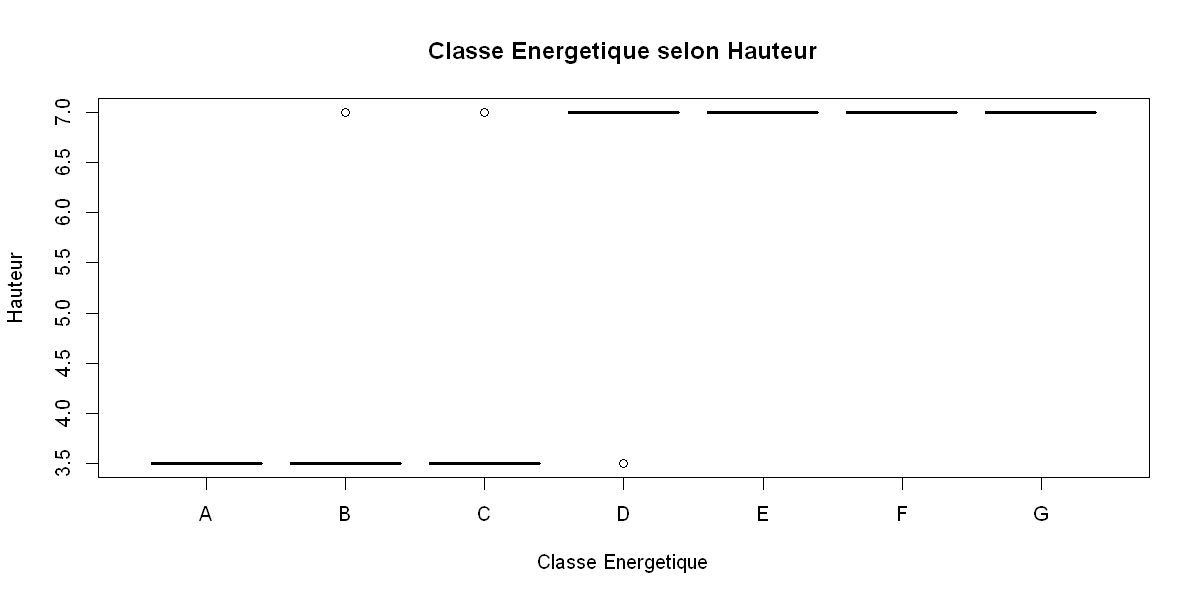

In [23]:
options(repr.plot.width = 10, repr.plot.height = 5) 
boxplot(x$Overall.height~ x$Energy.efficiency, main ="Classe Energetique selon Hauteur", xlab="Classe Energetique", ylab="Hauteur",col='red')

On remarque sur ce graphique que les classes A, B et C ont une hauteur de 3m50 tandis que les classes D, E, F et G ont une hauteur plus élevé (7m).

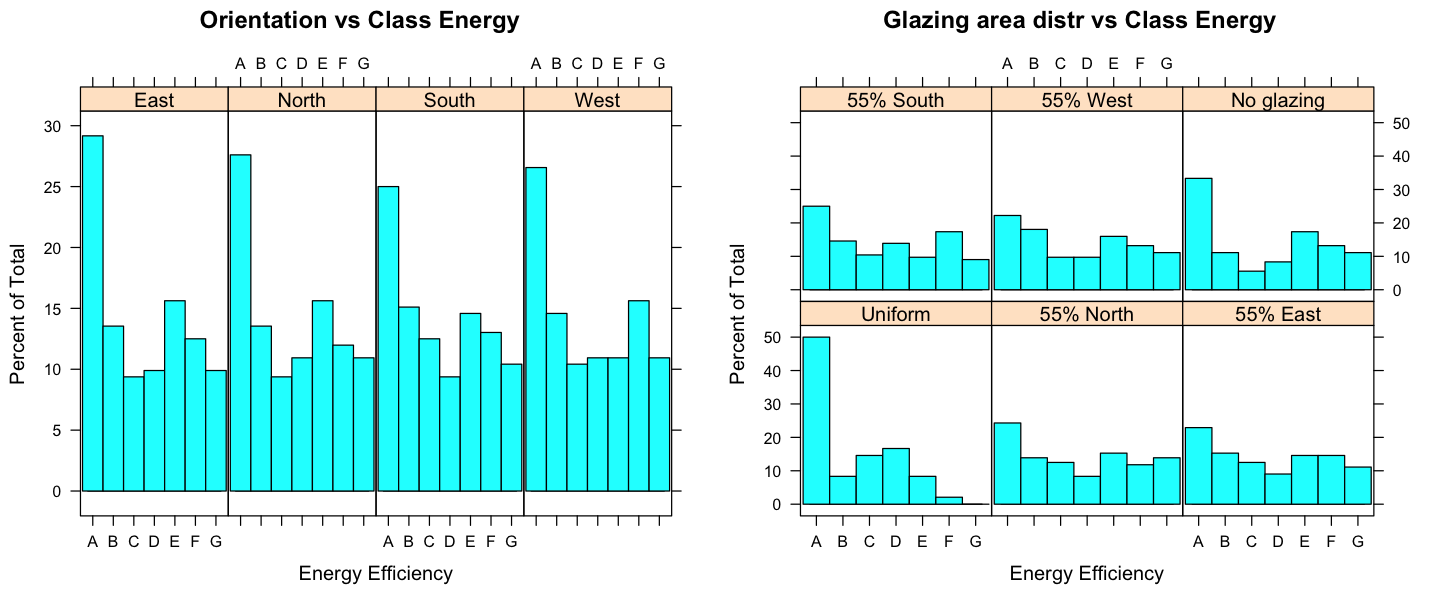

In [79]:
options(repr.plot.width = 12, repr.plot.height = 5) 
h1 = histogram(~Energy.efficiency | orientation , data=x, xlab= "Energy Efficiency",main="Orientation vs Class Energy",)
h2 = histogram(~Energy.efficiency | Glazing.area.distr, data=x,main="Glazing area distr vs Class Energy", xlab= "Energy Efficiency")
grid.arrange(h1, h2, nrow=1, ncol=2)
#histogram(~orientation | Energy.efficiency , data=x, xlab= "Energy Efficiency",main="Orientation vs Class Energy",)
#mosaicplot(table2, main="Glazing area distr vs Class Energy")

Les classes d'énergie sont uniformement réparties selon l'orientation du bâtiment et selon l'orientation des vitrages. L'orientation des bâtiments n'influe donc probablement pas l'appartenance à une certaine classe d'énergie.

En revanche, lorsqu'il y a pas de vitrage ou lorsque l'orientation des vitrages est uniforme, la classe A est majoritaire. (Logique, un batiment sans vitrage est mieux isolé)

## 3) Principal Component Analysis :

On enlève la variable Energy car c'est celle qu'on veut prédire.
On garde seulement les variables quantitatives.


**Remarque :** Les variables n'étant pas dans les mêmes unités, nous faisons une ACP réduite.

In [80]:
head(x)

Relative.compactness Wall.area Roof.area Overall.height orientation
1 0.9829276            306.4846  112.0027  7              North      
2 0.9835473            299.7763  110.0480  7              East       
3 0.9794535            303.3744  106.4084  7              South      
4 0.9777325            292.8122  113.0559  7              West       
5 0.9030294            316.2361  118.3664  7              North      
6 0.8909102            314.9162  121.8437  7              East       
  Glazing.area Glazing.area.distr Energy   Energy.efficiency
1 1.609490e-02 Uniform            34.26394 B                
2 1.352408e-02 Uniform            34.58975 B                
3 2.228103e-02 Uniform            38.77805 C                
4 9.554434e-06 Uniform            37.94781 C                
5 1.567076e-02 Uniform            47.67586 D                
6 1.425691e-02 Uniform            41.90847 C

In [81]:
X_acp <- dplyr::select(x,c(Relative.compactness, Roof.area, Wall.area,Overall.height, Glazing.area,Energy.efficiency))
head(X_acp)

Relative.compactness Roof.area Wall.area Overall.height Glazing.area
1 0.9829276            112.0027  306.4846  7              1.609490e-02
2 0.9835473            110.0480  299.7763  7              1.352408e-02
3 0.9794535            106.4084  303.3744  7              2.228103e-02
4 0.9777325            113.0559  292.8122  7              9.554434e-06
5 0.9030294            118.3664  316.2361  7              1.567076e-02
6 0.8909102            121.8437  314.9162  7              1.425691e-02
  Energy.efficiency
1 B                
2 B                
3 C                
4 C                
5 D                
6 C

In [82]:
res.pca <- PCA(X_acp, scale.unit=TRUE, quali.sup=6, graph = FALSE)

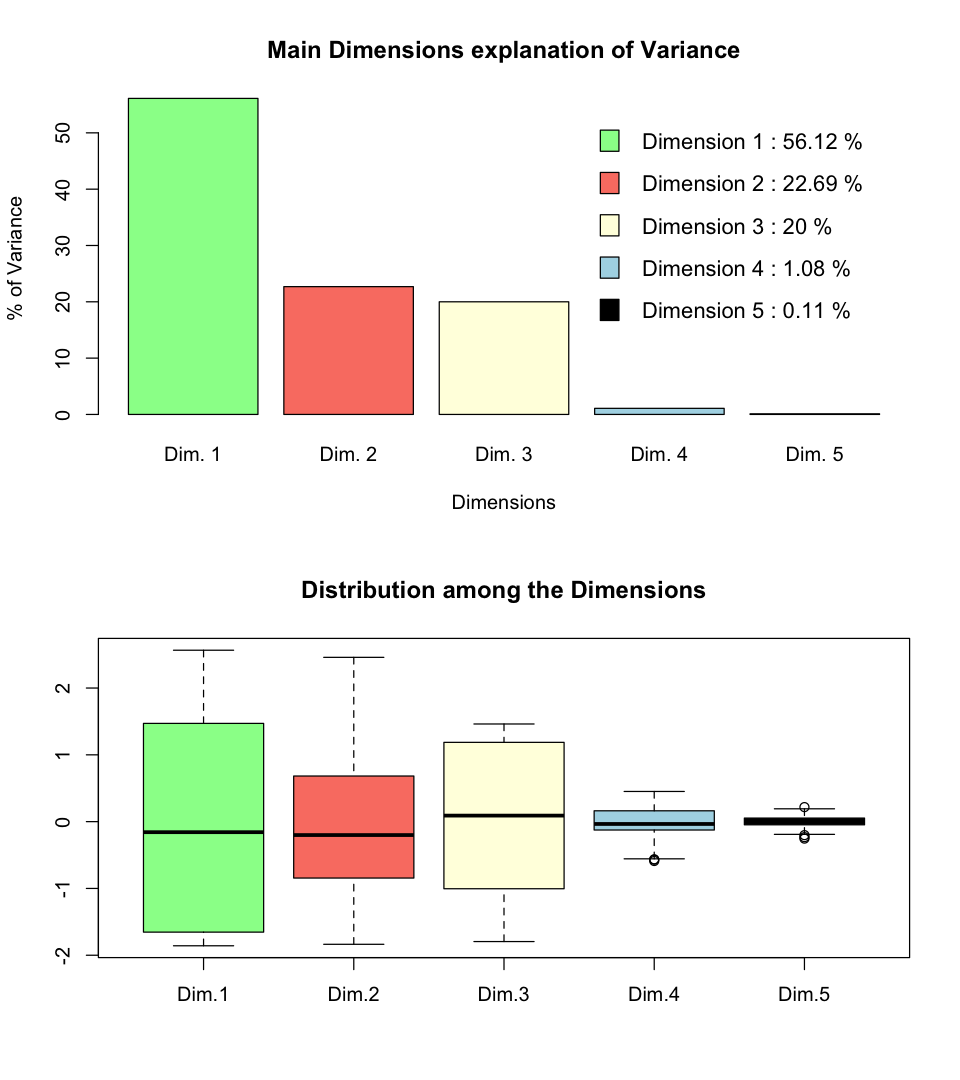

In [83]:
#fviz_eig(res.pca, addlabels = TRUE, ylim = c(0, 50), new.plot=FALSE, graph.type="classic")
lbls = paste("Dimension",1:5, ":", round(res.pca$eig[,2],2), "%" )
coul = c('palegreen','salmon','lightyellow','lightblue','black')
options(repr.plot.width = 8, repr.plot.height = 9) 
par(mfrow=c(2,1))
barplot(res.pca$eig[,2],names.arg=paste("Dim.",1:nrow(res.pca$eig)), xlab="Dimensions", ylab = "% of Variance", col = coul,main="Main Dimensions explanation of Variance")
legend(x='topright',legend=lbls, fill= coul, bty='n', cex=1.1, text.font=0.5)
boxplot(res.pca$ind$coord, outlier=TRUE, col=coul, main = "Distribution among the Dimensions")

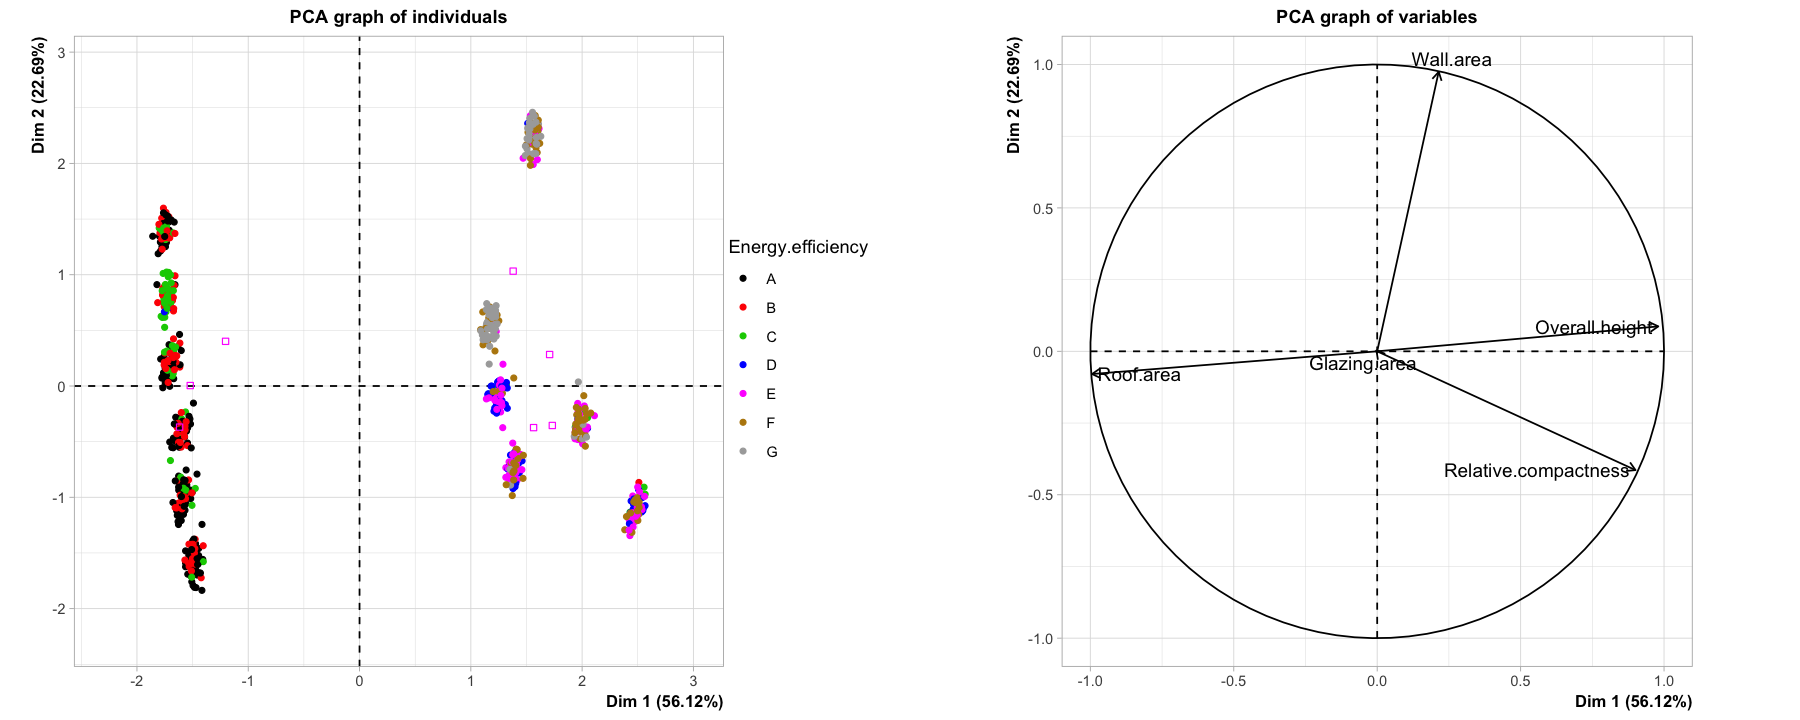

In [84]:
options(repr.plot.width = 15, repr.plot.height = 6) 
plot1 <- plot(res.pca,choix="ind", label="none", new.plot=FALSE, graph.type="ggplot",habillage=6)
plot2 <- plot(res.pca,choix="var", new.plot=FALSE, graph.type="ggplot")
grid.arrange(plot1, plot2, nrow=1, ncol=2)

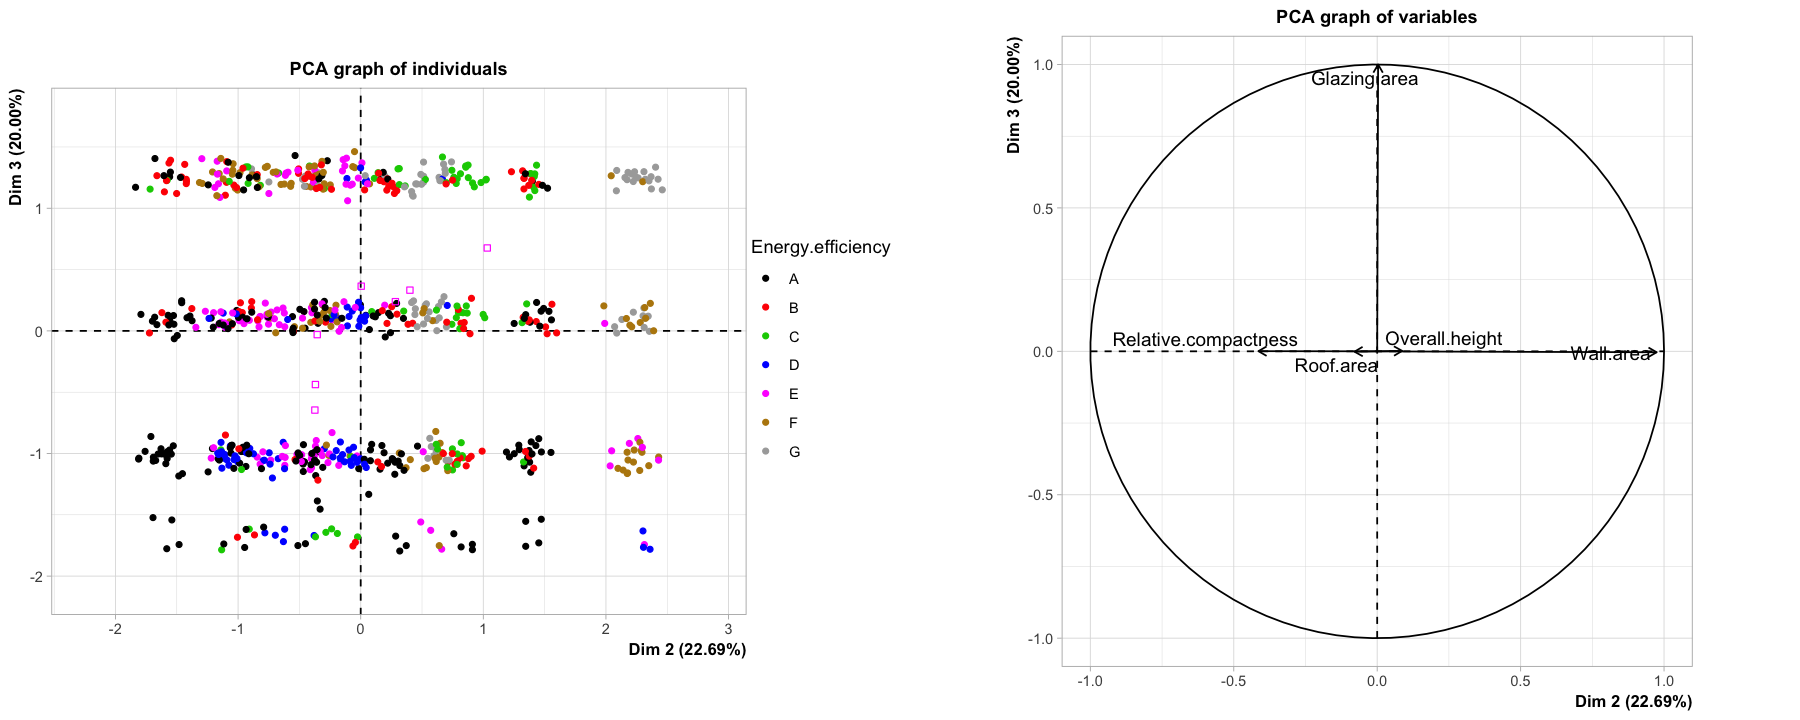

In [85]:
options(repr.plot.width = 15, repr.plot.height = 6) 
plot3 <- plot(res.pca,axes=c(2,3),choix="ind", label="none", new.plot=FALSE, graph.type="ggplot",habillage=6)
plot4 <- plot(res.pca,axes=c(2,3),choix="var", new.plot=FALSE, graph.type="ggplot")
grid.arrange(plot3, plot4, nrow=1, ncol=2)

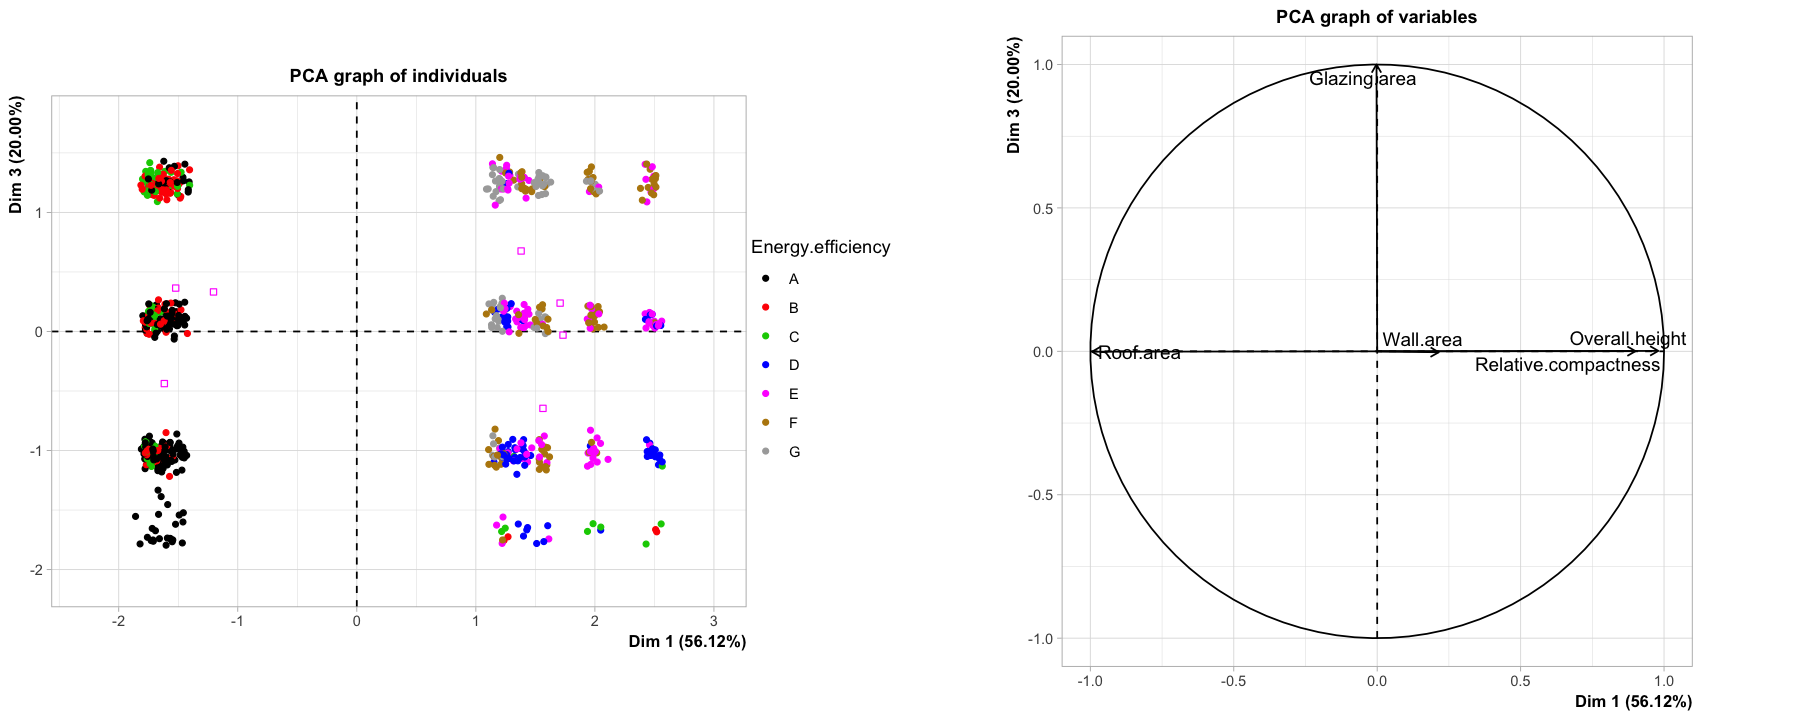

In [86]:
options(repr.plot.width = 15, repr.plot.height = 6) 
plot5 <- plot(res.pca, axes=c(1,3), choix="ind", label="none", new.plot=FALSE, graph.type="ggplot",habillage=6)
plot6 <- plot(res.pca, axes=c(1,3),choix="var", new.plot=FALSE, graph.type="ggplot")
grid.arrange(plot5, plot6, nrow=1, ncol=2)

**Interprétation** :

cf question énoncé

Partie 4 : Technique de clustering (non-supervisé) :
- K-means clustering


## 4) Clustering 

In [95]:
### k-means avec 7 clusters
x_num=dplyr::select(x, Relative.compactness, Wall.area,Roof.area,Overall.height, Glazing.area)
x_num_cr=scale(x_num)
km.out7 = kmeans(x_num_cr,centers=7)

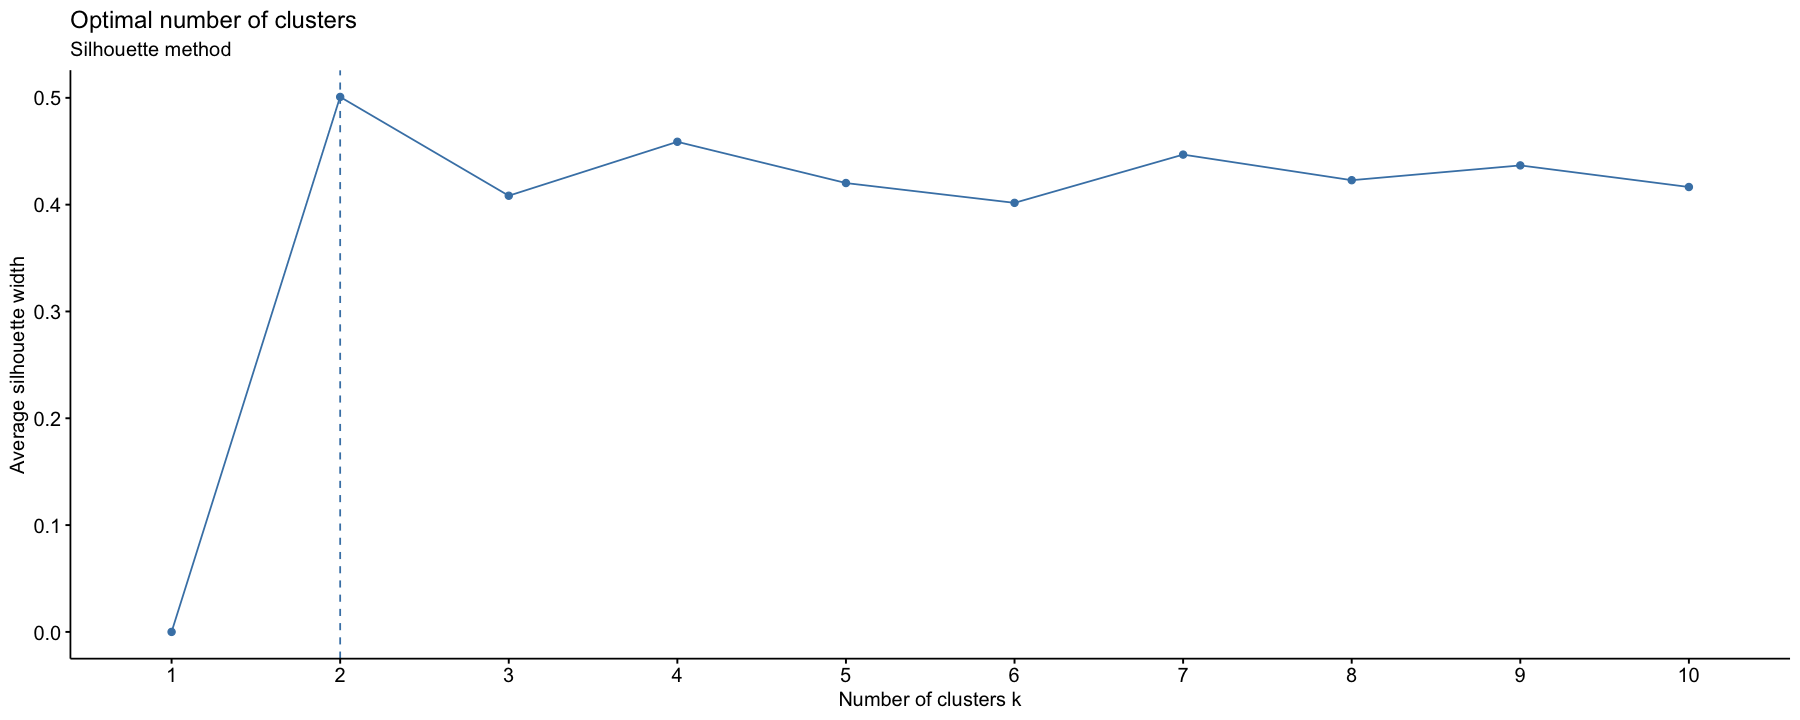

In [113]:
## Recherche du k optimum
# Silhouette method
fviz_nbclust(x_num_cr, kmeans, method = "silhouette")+
labs(subtitle = "Silhouette method")

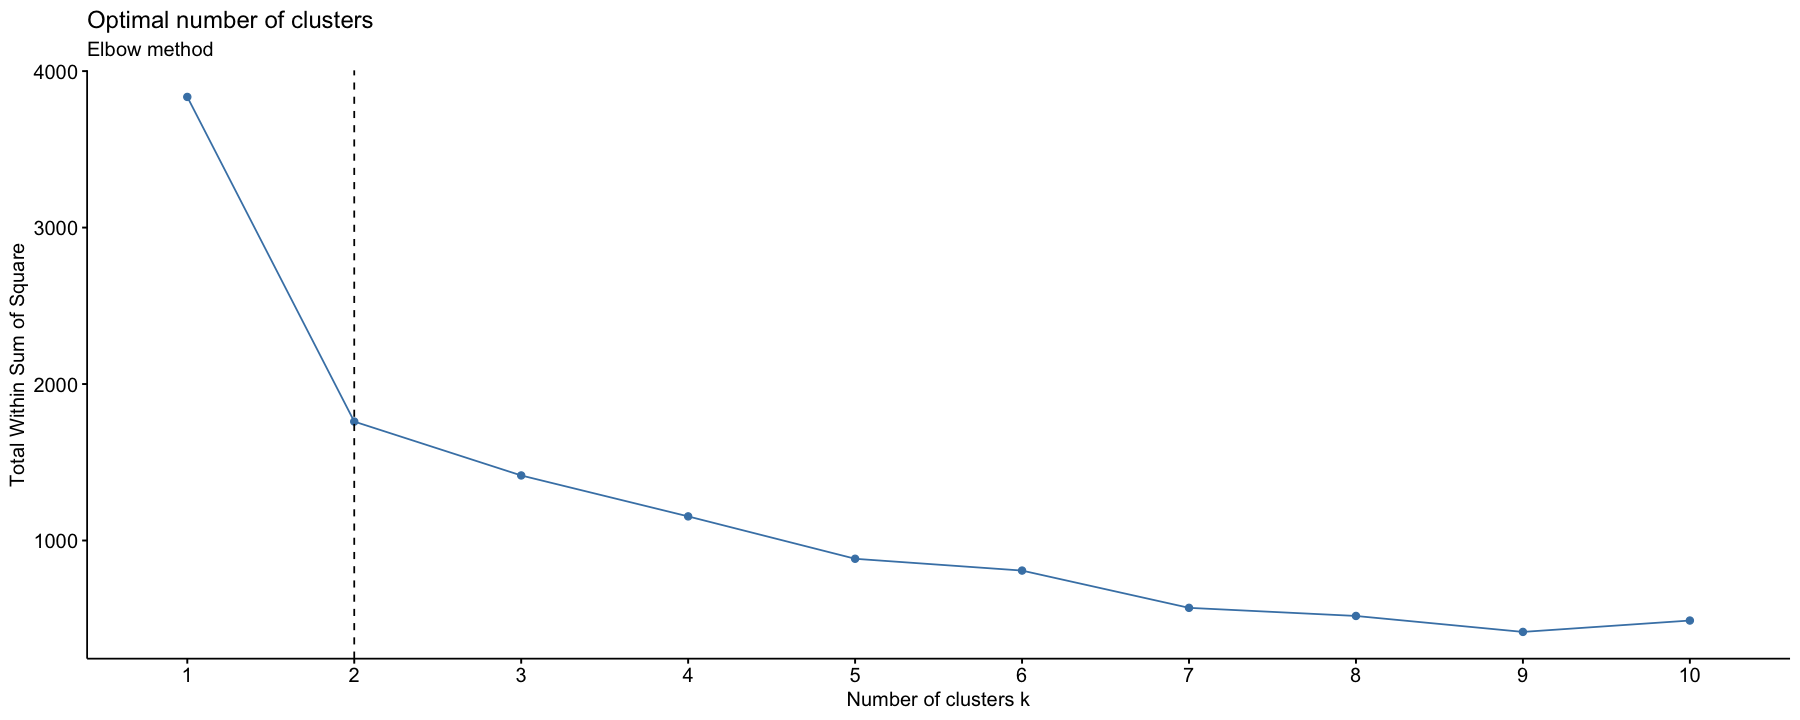

In [99]:
# Elbow method
fviz_nbclust(x_num_cr, kmeans, method = "wss") +
    geom_vline(xintercept = 2, linetype = 2)+
  labs(subtitle = "Elbow method")

Ces deux méthodes nous suggèrent 2 clusters, or on aimerait qu'il y en ai 7 (correspondant aux 7 classes énergétiques)

plot.kmean2<-fviz_cluster(km.out2, x_num_cr, ellipse.type = "norm", main='Kmeans with 2 clusters')
plot.kmean7<-fviz_cluster(km.out7, x_num_cr, ellipse.type = "norm", main='Kmeans with 7 clusters')
grid.arrange(plot.kmean2, plot.kmean7, nrow=1, ncol=2)

In [112]:
cat('Table de contingence avec 2 clusters :')

print(table(km.out2$cluster,x$Energy.efficiency))

cat(' \n\n ')
cat('Table de contingence avec 7 clusters :')
print(table(km.out7$cluster,x$Energy.efficiency))

Table de contingence avec 2 clusters :   
      A   B   C   D   E   F   G
  1   0   4  11  77 109 102  81
  2 208 105  69   2   0   0   0
 

 Table de contingence avec 7 clusters :   
      A   B   C   D   E   F   G
  1  34  54  49   2   0   0   0
  2  73  17  11   0   0   0   0
  3   0   0   0   6  51  54   9
  4 101  34   9   0   0   0   0
  5   0   0   0  18  18   7  37
  6   0   4  11  50  32  16   7
  7   0   0   0   3   8  25  28


kmeans ne semble pas adapté à notre problème. Cependant, cet algorithme suggère de regrouper les classes A,B et C ensemble ainsi que D,E,F,G (bonne consommation et mauvaise consommation).

# C- Data splitting :

In [115]:
## 75% of the sample size
train_ratio=0.75
smp_size <- floor(train_ratio * nrow(x))

## set the seed to make your partition reproducible
set.seed(2512)
train_ind <- sample(seq_len(nrow(x)), size = smp_size)

x_train <- x[train_ind, ]
x_test <- x[-train_ind, ]

# D - Models :

## 1) Classification Problem :  

In this part we focus only on the classification problem, which is to predict in which energy Efficiency class an individual will be. Therefore, we remove the Variable Energy in this part.

In [116]:
x_train_reg <- dplyr::select(x_train, Relative.compactness, Wall.area,Roof.area,Overall.height,orientation, Glazing.area,Glazing.area.distr,Energy.efficiency)
x_test_reg <- dplyr::select(x_test, Relative.compactness, Wall.area,Roof.area,Overall.height,orientation, Glazing.area,Glazing.area.distr,Energy.efficiency)

### a) Logistic Regression : 

We are going to perform a polynomial orderded logistic regression.

There are tow ways of doing so : additive logits and adjacents logits.

We first define a simple model that we call **m0**.

In [122]:
#Additive Simple: 
m0 <- vglm(Energy.efficiency ~., data=x_train_reg, family=cumulative(parallel=T, reverse=F))
p <- predict(m0, newdata = x_test_reg, type = "response") #matrice de proba d'appartenance à chaque classe
prediction <- apply(p,1, which.max) 
result1 = table(pred.reg = prediction,observations = x_test_reg$Energy.efficiency); result1
score_logit_1 = sum(diag(result1))/sum(result1); 

cat('Score de classification :',score_logit_1)

        observations
pred.reg  A  B  C  D  E  F  G
       1 38  9  5  0  0  0  0
       2  4 13  7  1  0  0  0
       3  3  3 12  1  0  0  0
       4  0  1  1  9  7  0  0
       5  0  0  1  8 14 10  1
       6  0  0  0  2  6 15  5
       7  0  0  0  2  2  2 10

Score de classification : 0.578125

**Commentaire :** 

Le score de classification est relativement faible, cependant, les erreurs de classification sont majoritairement dans les classes voisines.

In [123]:
# A DEMANDER AU PROF SI ON UTILISE LES 2 METHODES 
#Adjacents simple: 
#m0_c <- vglm(Energy.efficiency ~., data=x_train_reg, family=acat(parallel=F, reverse=F))
#p <- predict(m0_c, newdata = x_test_reg, type = "response")
#prediction <- apply(p,1, which.max)
#result2 = table(pred.reg = prediction,observations = x_test_reg$Energy.efficiency); result2
#score_logit_2 = sum(diag(result2))/sum(result2); score_logit_2

In [93]:
# A LA MAIN DE MAX
#proba_m0_cumul = exp(m0@predictors)/(1+exp(m0@predictors))
#head(proba_m0_cumul) #attention ne pas tenir compte de l'en tête pour la sortie de cette commande,
#la vraie en-tête devrait juste être : P(Y<=1) P(Y<=2) ... P(Y<=6) P(Y<=7)
#La commande ne sort pas la dernière en tête car elle vaut tout simplement 1 - P(Y<=6)
#on calcule maintenant les probas d'être dans chaque classe :
#proba_m0 <- proba_m0_cumul[,1]
#M = dim(proba_m0_add_cumul)[2]
#for (j in seq(1,M-1)){
#proba_m0 <- cbind(proba_m0,proba_m0_cumul[,j+1]-proba_m0_cumul[,j])
#}
#proba_m0 <- cbind(proba_m0, (1-proba_m0_cumul[,M]))

### FAIRE METHODE CECILE

### b) Regression Logistique Pénalisée : 

### c) Arbre de regression : 

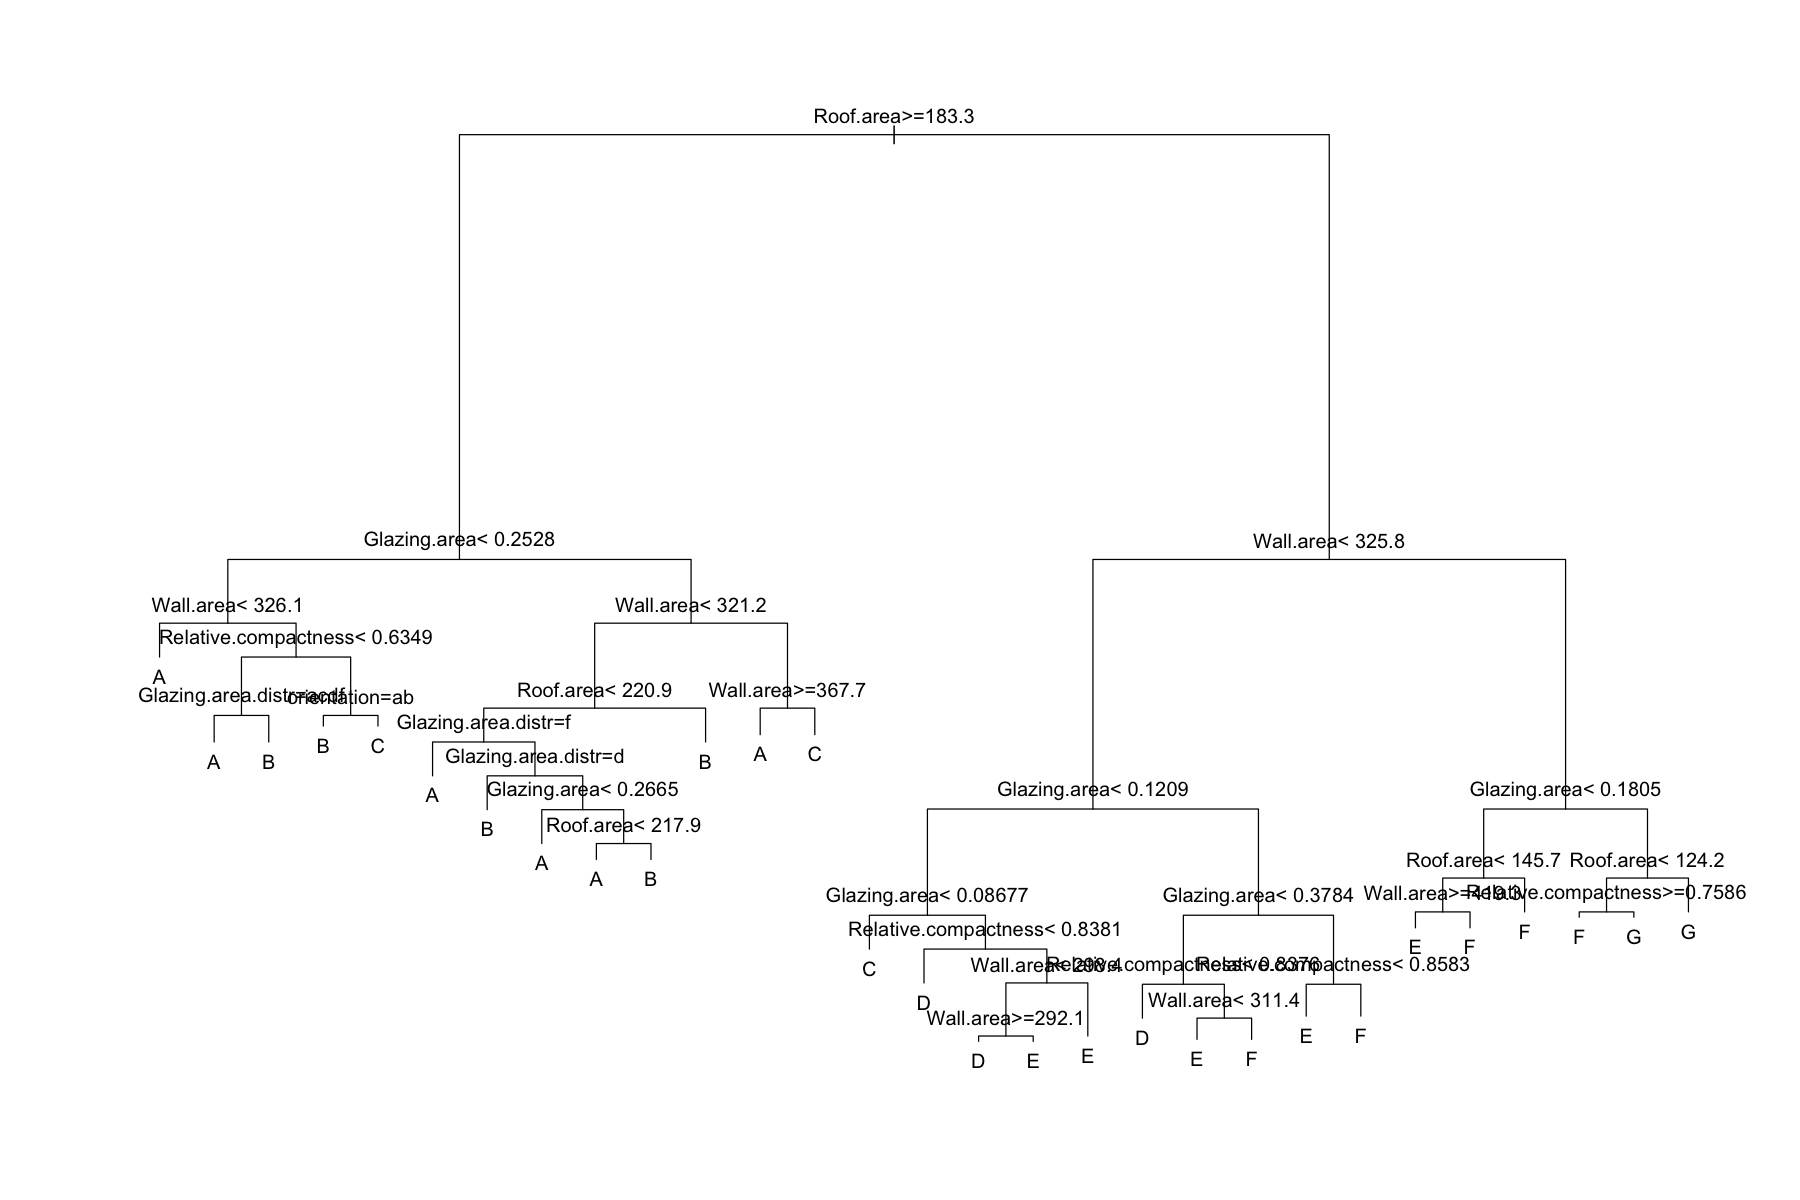

In [136]:
options(repr.plot.width = 15, repr.plot.height = 10)
tree.c=rpart(Energy.efficiency~.,data=x_train_reg,control=rpart.control(cp=0.001))
# La commande ci-dessous fournit un descriptif de l'arbre obtenu

plot(tree.c)
text(tree.c)

On voit sur ce premier arbre que la variable Roof.area a une très grande influence sur la classification énergétique. 

Déterminons maintenant le meilleur paramètre de complexité (cp) qui a pour but d'élaguer l'arbre.

cp opti : 0.008144275

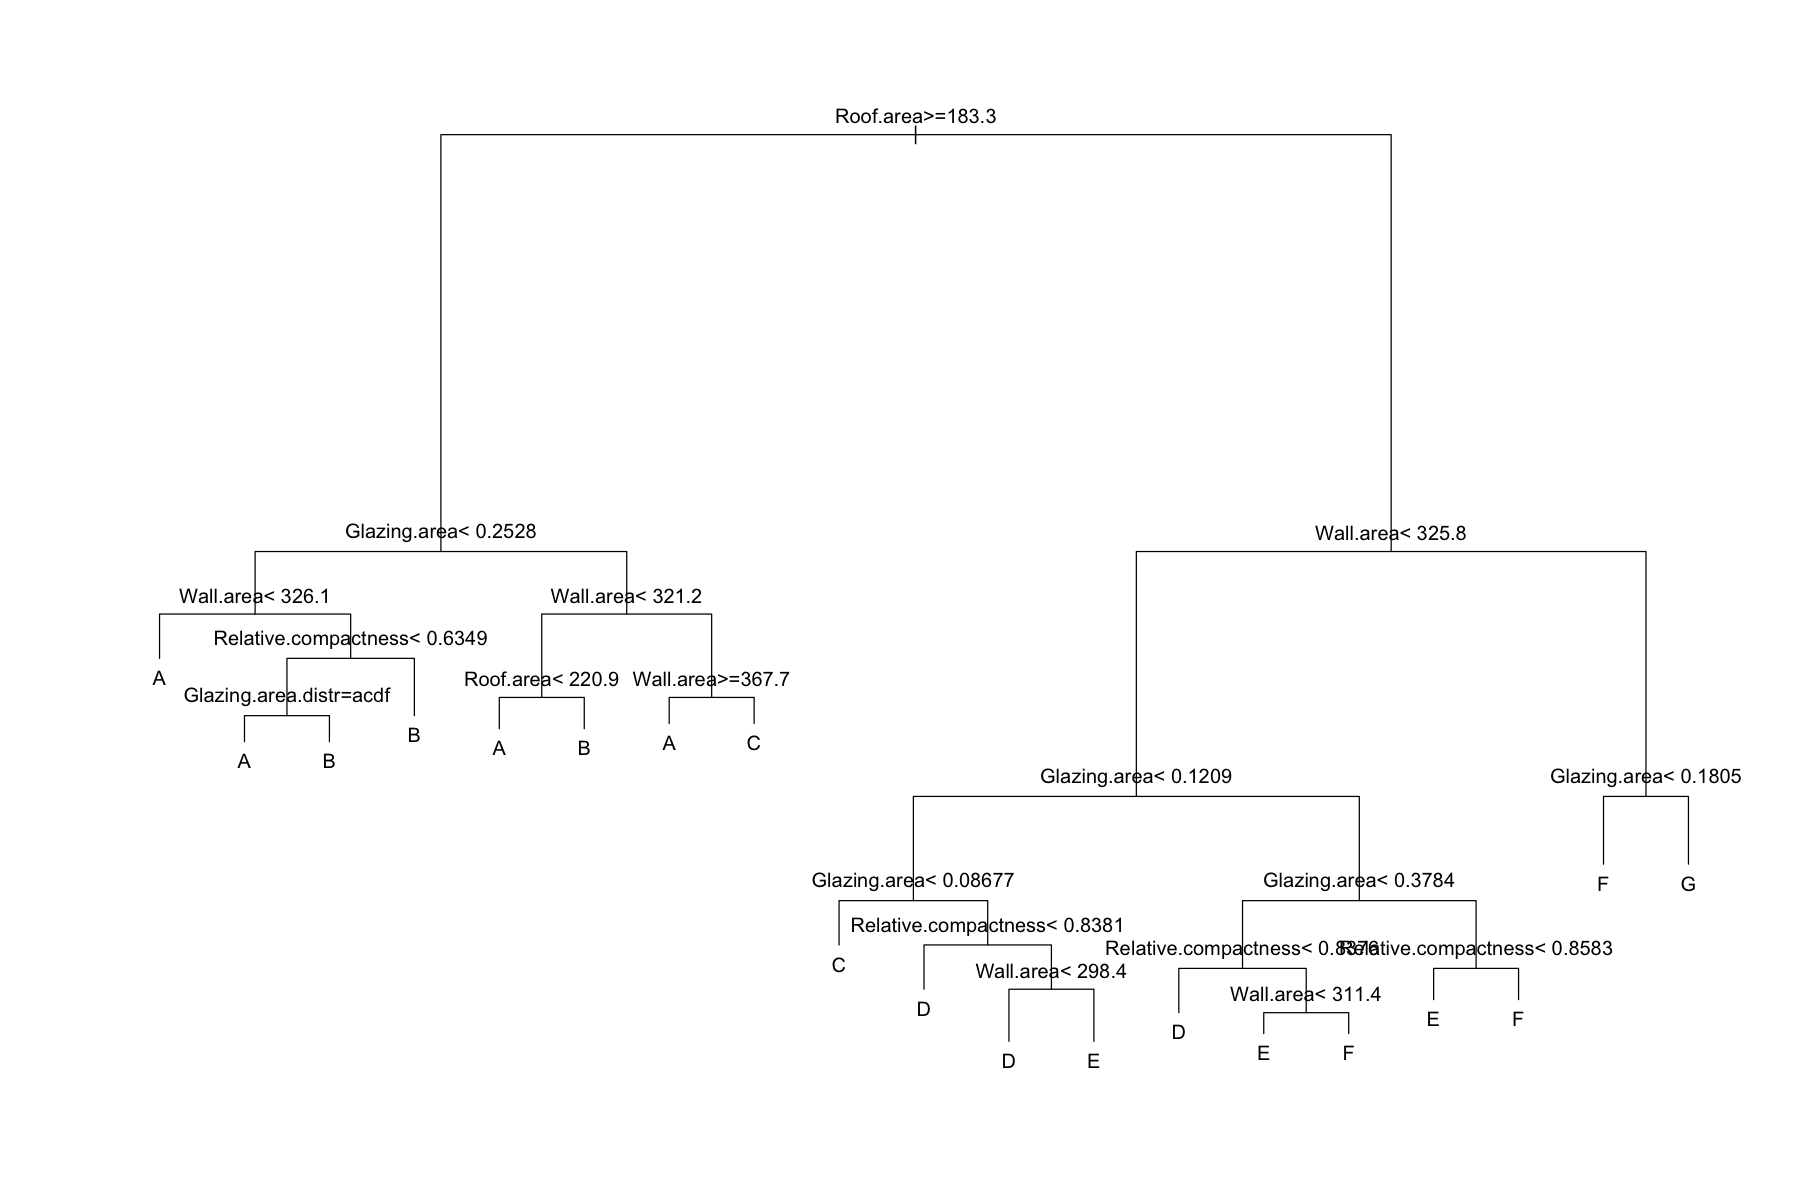

In [135]:
xmat=xpred.rpart(tree.c, xval = 10)
#levels(datappr[,"Survived"]) <- c(1,2)
xerr <- (xmat-as.numeric(x_train_reg[, "Energy.efficiency"]))^2
CVerr=apply(xerr,2,sum)
#CVerr  #    CP           erreur
cp_opti = as.numeric(attributes(which.min(CVerr))$names); 

cat('cp opti :', cp_opti)

tree.c=rpart(Energy.efficiency~.,data=x_train_reg,control=rpart.control(cp=cp_opti))
options(repr.plot.width = 15, repr.plot.height = 10)
plot(tree.c)
text(tree.c)

### d) Random Forest : 